**most requested blood group per week and month**

In [7]:
import pandas as pd
from datetime import datetime, timedelta
data = [
    {"type": "A+", "date": "2024-12-01", "request": 12},
    {"type": "A+", "date": "2024-12-02", "request": 15},
    {"type": "B-", "date": "2024-12-02", "request": 10},
    {"type": "O+", "date": "2024-12-03", "request": 22},
    {"type": "A+", "date": "2024-12-04", "request": 11},
    {"type": "B-", "date": "2024-12-05", "request": 16},
    {"type": "O+", "date": "2024-12-06", "request": 18},
]

df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['date'])

today = df['date'].max()

week_start = today - timedelta(days=6)  # Last 7 days including today
df_week = df[(df['date'] >= week_start) & (df['date'] <= today)]
weekly_summary = df_week.groupby('type')['request'].sum().reset_index()
most_requested_week = weekly_summary.sort_values(by='request', ascending=False).iloc[0]

month_start = today.replace(day=1)
df_month = df[(df['date'] >= month_start) & (df['date'] <= today)]
monthly_summary = df_month.groupby('type')['request'].sum().reset_index()
most_requested_month = monthly_summary.sort_values(by='request', ascending=False).iloc[0]

result = {
    "most_requested_this_week": {
        "type": most_requested_week['type'],
        "total_requests": int(most_requested_week['request'])
    },
    "most_requested_this_month": {
        "type": most_requested_month['type'],
        "total_requests": int(most_requested_month['request'])
    }
}

print(result)

{'most_requested_this_week': {'type': 'O+', 'total_requests': 40}, 'most_requested_this_month': {'type': 'O+', 'total_requests': 40}}


In [8]:
import pandas as pd
from datetime import timedelta
from sklearn.linear_model import LinearRegression
import numpy as np

data = [
    {"type": "A+", "date": "2024-12-01", "request": 12},
    {"type": "A+", "date": "2024-12-02", "request": 15},
    {"type": "A+", "date": "2024-12-03", "request": 18},
    {"type": "B-", "date": "2024-12-01", "request": 9},
    {"type": "B-", "date": "2024-12-02", "request": 10},
    {"type": "B-", "date": "2024-12-03", "request": 11},
    {"type": "O+", "date": "2024-12-01", "request": 22},
    {"type": "O+", "date": "2024-12-02", "request": 25},
    {"type": "O+", "date": "2024-12-03", "request": 30}
]

df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['date'])

trend_scores = []

for bt in df['type'].unique():
    df_bt = df[df['type'] == bt].copy()
    df_bt = df_bt.groupby('date')['request'].sum().reset_index()

    df_bt['date_ordinal'] = df_bt['date'].map(lambda x: x.toordinal())

    X = df_bt[['date_ordinal']]
    y = df_bt['request']
    model = LinearRegression().fit(X, y)
    slope = model.coef_[0]

    trend_scores.append({
        "type": bt,
        "avg_demand": y.mean(),
        "demand_trend_slope": slope
    })

trend_df = pd.DataFrame(trend_scores)

recommended_type = trend_df.sort_values(by='demand_trend_slope', ascending=False).iloc[0]

print({
    "recommended_to_stock": recommended_type['type'],
    "reason": f"Demand increasing at slope {recommended_type['demand_trend_slope']:.2f} (avg demand = {recommended_type['avg_demand']:.1f})"
})

{'recommended_to_stock': 'O+', 'reason': 'Demand increasing at slope 4.00 (avg demand = 25.7)'}


**Linear Regression for a week for each blood group to predict request number**

In [9]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.linear_model import LinearRegression

np.random.seed(42)

blood_types = ['A+', 'B-', 'O+', 'AB+', 'A-']
locations = [
    {"city": "Fairfax", "lat": 38.8462, "lon": -77.3064},
    {"city": "Arlington", "lat": 38.8816, "lon": -77.0910},
    {"city": "Alexandria", "lat": 38.8048, "lon": -77.0469},
    {"city": "Springfield", "lat": 38.7893, "lon": -77.1872},
    {"city": "Reston", "lat": 38.9586, "lon": -77.3570}
]

start_date = pd.to_datetime("2024-11-01")
days = 30
synthetic_data = []

for bt in blood_types:
    base_demand = np.random.randint(5, 15)
    slope = np.random.uniform(0.5, 1.5)
    location = np.random.choice(locations)

    for i in range(days):
        date = start_date + timedelta(days=i)
        daily_trend = base_demand + i * slope + np.random.normal(0, 2)
        request = max(int(daily_trend), 0)

        synthetic_data.append({
            "type": bt,
            "date": date.strftime("%Y-%m-%d"),
            "request": request,
            "latitude": location["lat"],
            "longitude": location["lon"]
        })

df_synthetic = pd.DataFrame(synthetic_data)
df_synthetic['date'] = pd.to_datetime(df_synthetic['date'])

forecast_days = 7
future_start = df_synthetic['date'].max() + timedelta(days=1)
future_dates = [future_start + timedelta(days=i) for i in range(forecast_days)]

daily_predictions = []

for bt in df_synthetic['type'].unique():
    df_bt = df_synthetic[df_synthetic['type'] == bt].copy()
    df_bt = df_bt.groupby('date')['request'].sum().reset_index()
    df_bt['day_num'] = df_bt['date'].map(lambda x: x.toordinal())

    X = df_bt[['day_num']]
    y = df_bt['request']

    model = LinearRegression().fit(X, y)

    future_day_nums = [[d.toordinal()] for d in future_dates]
    preds = model.predict(future_day_nums)

    for i, date in enumerate(future_dates):
        daily_predictions.append({
            "type": bt,
            "date": date.strftime("%Y-%m-%d"),
            "predicted_requests": int(round(preds[i]))
        })

df_daily_predictions = pd.DataFrame(daily_predictions)
print(df_daily_predictions)

   type        date  predicted_requests
0    A+  2024-12-01                  49
1    A+  2024-12-02                  51
2    A+  2024-12-03                  52
3    A+  2024-12-04                  53
4    A+  2024-12-05                  55
5    A+  2024-12-06                  56
6    A+  2024-12-07                  57
7    B-  2024-12-01                  41
8    B-  2024-12-02                  42
9    B-  2024-12-03                  43
10   B-  2024-12-04                  44
11   B-  2024-12-05                  45
12   B-  2024-12-06                  47
13   B-  2024-12-07                  48
14   O+  2024-12-01                  46
15   O+  2024-12-02                  47
16   O+  2024-12-03                  48
17   O+  2024-12-04                  50
18   O+  2024-12-05                  51
19   O+  2024-12-06                  52
20   O+  2024-12-07                  53
21  AB+  2024-12-01                  50
22  AB+  2024-12-02                  51
23  AB+  2024-12-03                  52


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


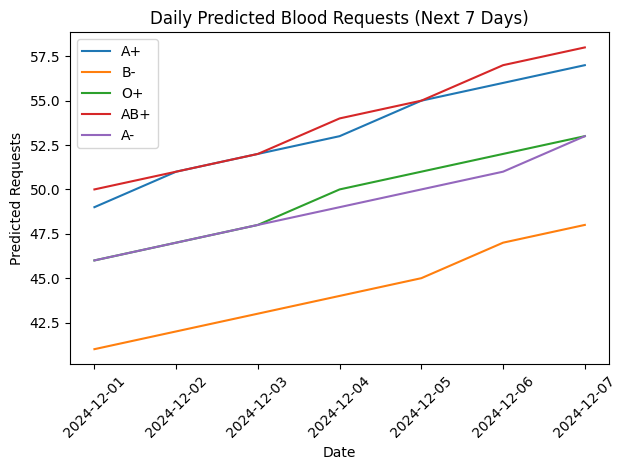

In [10]:
import matplotlib.pyplot as plt

for bt in df_daily_predictions['type'].unique():
    subset = df_daily_predictions[df_daily_predictions['type'] == bt]
    plt.plot(subset['date'], subset['predicted_requests'], label=bt)

plt.title("Daily Predicted Blood Requests (Next 7 Days)")
plt.xlabel("Date")
plt.ylabel("Predicted Requests")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

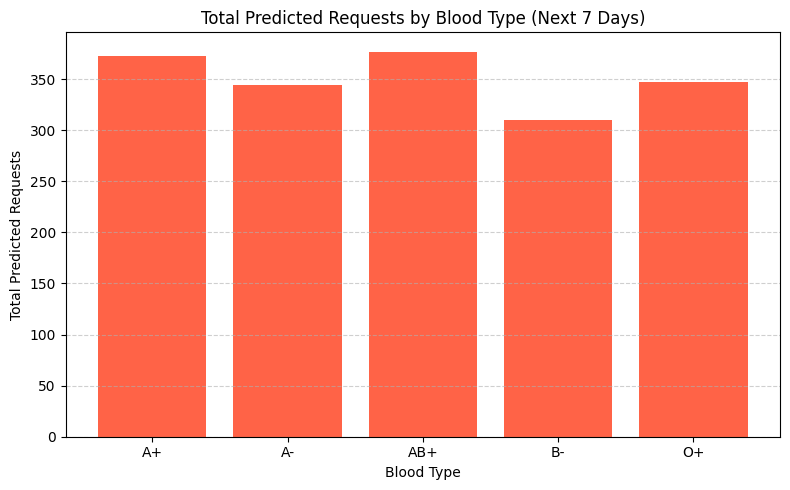

In [11]:
weekly_totals = df_daily_predictions.groupby('type')['predicted_requests'].sum().reset_index()

plt.figure(figsize=(8, 5))
plt.bar(weekly_totals['type'], weekly_totals['predicted_requests'], color='tomato')
plt.title("Total Predicted Requests by Blood Type (Next 7 Days)")
plt.xlabel("Blood Type")
plt.ylabel("Total Predicted Requests")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

**Actual vs Predicted values to test Model Accurary on a particular blood group**

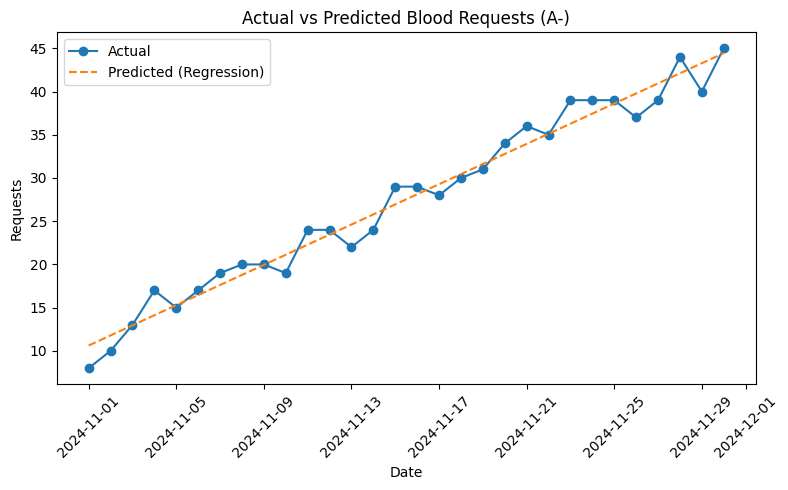

In [12]:
import matplotlib.pyplot as plt

# Train your model
df_bt['day_num'] = df_bt['date'].map(lambda x: x.toordinal())
X = df_bt[['day_num']]
y = df_bt['request']
model = LinearRegression().fit(X, y)

# Predict on the same days (in-sample prediction)
df_bt['predicted'] = model.predict(X)

# Plot actual vs predicted
plt.figure(figsize=(8, 5))
plt.plot(df_bt['date'], df_bt['request'], label='Actual', marker='o')
plt.plot(df_bt['date'], df_bt['predicted'], label='Predicted (Regression)', linestyle='--')
plt.title(f"Actual vs Predicted Blood Requests ({bt})")
plt.xlabel("Date")
plt.ylabel("Requests")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**MAE(Mean Absolute Error) and R² score for Linear Regression**

In [14]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

df_bt = df_synthetic[df_synthetic['type'] == 'A+'].copy()
df_bt = df_bt.groupby('date')['request'].sum().reset_index()
df_bt['day_num'] = df_bt['date'].map(lambda x: x.toordinal())

X = df_bt[['day_num']]
y = df_bt['request']

model = LinearRegression().fit(X, y)

y_pred = model.predict(X)

# Calculate MAE and R² Score
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.2f}")


Mean Absolute Error (MAE): 1.41
R² Score: 0.97
